# Classification and Class Activation Map




In [1]:
import keras
from keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential,Model
from keras.layers import Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D
import scipy as sp

In [20]:
# load the Fashion MNIST dataset
(X_train,Y_train),(X_test,Y_test)  = fashion_mnist.load_data()

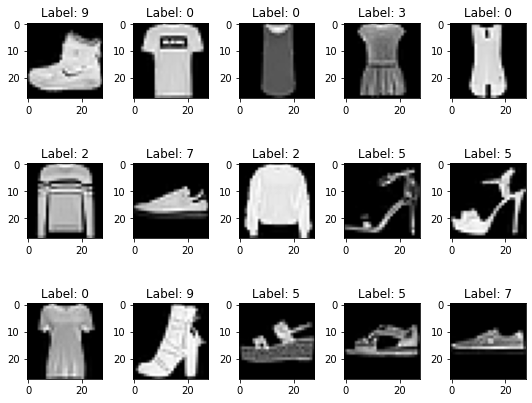

In [22]:
num_row = 3
num_col = 5
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num_row*num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(X_train[i], cmap='gray')
    ax.set_title('Label: {}'.format(Y_train[i]))
plt.tight_layout()
plt.show()

In [25]:
# Put an additional axis for the channels of the image.
X_train = X_train.reshape(60000,28,28,1)
X_test = X_test.reshape(10000,28,28,1)

# Normalize the pixel values from 0 to 1
X_train = X_train/255
X_test  = X_test/255

# Cast to float
X_train = X_train.astype('float')
X_test  = X_test.astype('float')

## Classification

In [4]:
# use the Sequential API
model = Sequential()

# notice the padding parameter to recover the lost border pixels when doing the convolution
model.add(Conv2D(16,input_shape=(28,28,1),kernel_size=(3,3),activation='relu',padding='same'))
# pooling layer with a stride of 2 will reduce the image dimensions by half
model.add(MaxPooling2D(pool_size=(2,2)))

# pass through more convolutions with increasing filters
model.add(Conv2D(32,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,kernel_size=(3,3),activation='relu',padding='same'))

# use global average pooling to take into account lesser intensity pixels
model.add(GlobalAveragePooling2D())

# output class probabilities
model.add(Dense(10,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 64)         0

In [59]:
# configure the training
model.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

# train the model. just run a few epochs for this test run. you can adjust later.
history = model.fit(X_train,Y_train,batch_size=32, epochs=5, validation_split=0.1, shuffle=True)


Epoch 1/5
1688/1688 [==============================] - 40s 24ms/step - loss: 0.0179 - accuracy: 0.9941 - val_loss: 0.7391 - val_accuracy: 0.9088
Epoch 2/5
1688/1688 [==============================] - 39s 23ms/step - loss: 0.0175 - accuracy: 0.9942 - val_loss: 0.7514 - val_accuracy: 0.9120
Epoch 3/5
1688/1688 [==============================] - 40s 23ms/step - loss: 0.0154 - accuracy: 0.9950 - val_loss: 0.7740 - val_accuracy: 0.9092
Epoch 4/5
1688/1688 [==============================] - 40s 24ms/step - loss: 0.0163 - accuracy: 0.9945 - val_loss: 0.7640 - val_accuracy: 0.9105
Epoch 5/5
1688/1688 [==============================] - 40s 24ms/step - loss: 0.0142 - accuracy: 0.9953 - val_loss: 0.7094 - val_accuracy: 0.9075


prediction : Sandal
Actual : Sandal


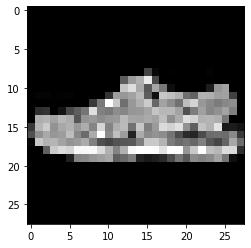

In [57]:
label = ['T-shirt','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
predictions = model.predict(X_test)

plt.imshow(X_test[21].reshape((28,28)),'gray')
print ("prediction :", label[np.argmax(np.round(predictions[21]))])
print ("Actual :", label[Y_test[21]])

In [41]:
name = ['apple','pear']
name[1]

'pear'

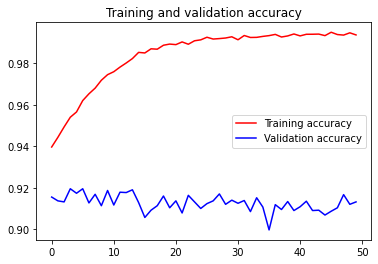

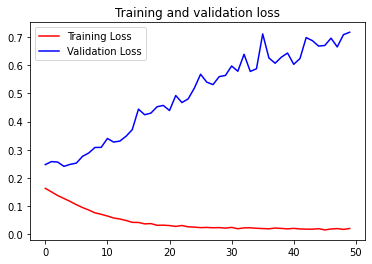

In [58]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Class Activation Map

In [6]:
# class activation map, same as previous model but with an additional output
cam_model  = Model(inputs=model.input,outputs=(model.layers[-3].output,model.layers[-1].output))

In [7]:
# get the features and results of the test images using the newly created model
features,results = cam_model.predict(X_test)

In [8]:
# these are the weights going into the softmax layer
last_dense_layer = model.layers[-1]

# get the weights list.  index 0 contains the weights, index 1 contains the biases
gap_weights_l = last_dense_layer.get_weights()

print("gap_weights_l index 0 contains weights ", gap_weights_l[0].shape)
print("gap_weights_l index 1 contains biases ", gap_weights_l[1].shape)

# shows the number of features per class, and the total number of classes
# Store the weights
gap_weights = gap_weights_l[0]

print(f"There are {gap_weights.shape[0]} feature weights and {gap_weights.shape[1]} classes.")

gap_weights_l index 0 contains weights  (128, 10)
gap_weights_l index 1 contains biases  (10,)
There are 128 feature weights and 10 classes.


In [9]:
def show_cam(image_index):
  '''displays the class activation map of a particular image'''

  # takes the features of the chosen image
  features_for_img = features[image_index,:,:,:]

  # get the class with the highest output probability
  prediction = np.argmax(results[image_index])

  # get the gap weights at the predicted class
  class_activation_weights = gap_weights[:,prediction]

  # upsample the features to the image's original size (28 x 28)
  class_activation_features = sp.ndimage.zoom(features_for_img, (28/3, 28/3, 1), order=2)

  # compute the intensity of each feature in the CAM
  cam_output  = np.dot(class_activation_features,class_activation_weights)
  
  print('Predicted Class = ' +str(prediction)+ ', Probability = ' + str(results[image_index][prediction]))
  
  # show the upsampled image
  plt.imshow(np.squeeze(X_test[image_index],-1), alpha=0.5)
  
  # strongly classified (95% probability) images will be in green, else red
  if results[image_index][prediction]>0.95:
    cmap_str = 'Greens'
  else:
    cmap_str = 'Reds'

  # overlay the cam output
  plt.imshow(cam_output, cmap=cmap_str, alpha=0.5)

  # display the image
  plt.show()

In [10]:
def show_maps(desired_class, num_maps):
    '''
    goes through the first 10,000 test images and generates CAMs 
    for the first `num_maps`(int) of the `desired_class`(int)
    '''

    counter = 0

    if desired_class < 10:
        print("please choose a class less than 10")

    # go through the first 10000 images
    for i in range(0,10000):
        # break if we already displayed the specified number of maps
        if counter == num_maps:
            break

        # images that match the class will be shown
        if np.argmax(results[i]) == desired_class:
            counter += 1
            show_cam(i)

please choose a class less than 10
Predicted Class = 8, Probability = 0.9982179


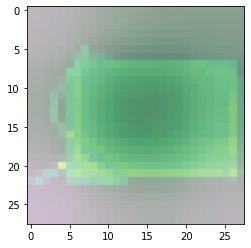

Predicted Class = 8, Probability = 1.0


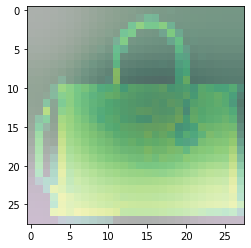

Predicted Class = 8, Probability = 0.99881256


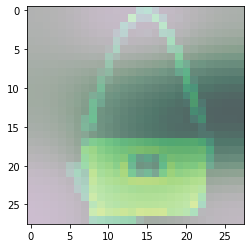

Predicted Class = 8, Probability = 0.99995434


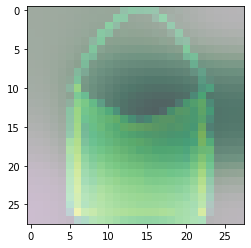

Predicted Class = 8, Probability = 0.8575483


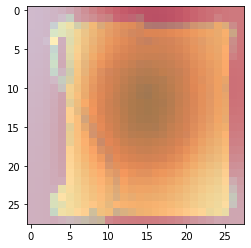

Predicted Class = 8, Probability = 0.9999902


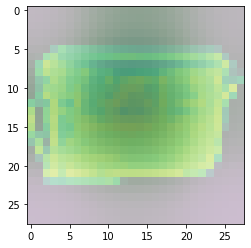

Predicted Class = 8, Probability = 0.9971935


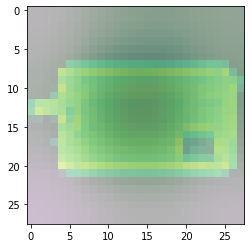

Predicted Class = 8, Probability = 0.99996173


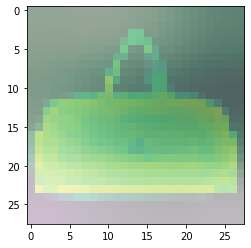

Predicted Class = 8, Probability = 0.9999999


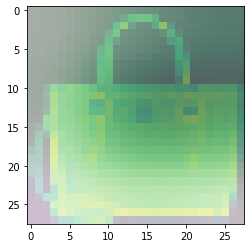

Predicted Class = 8, Probability = 0.99843174


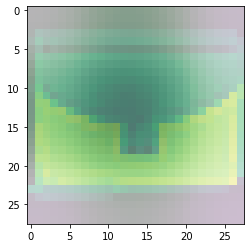

Predicted Class = 8, Probability = 0.99992347


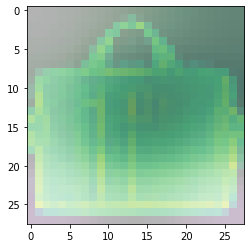

Predicted Class = 8, Probability = 0.99727577


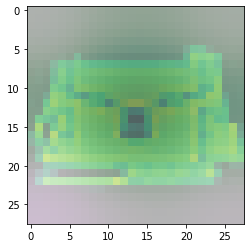

Predicted Class = 8, Probability = 0.9975032


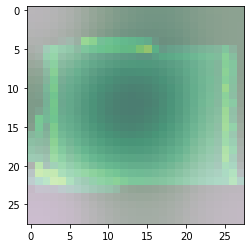

Predicted Class = 8, Probability = 0.99861896


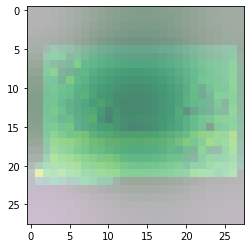

Predicted Class = 8, Probability = 0.9989511


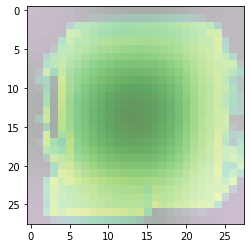

Predicted Class = 8, Probability = 0.99999976


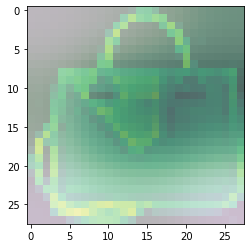

Predicted Class = 8, Probability = 0.99361527


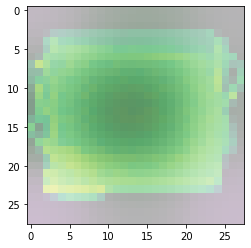

Predicted Class = 8, Probability = 0.9995797


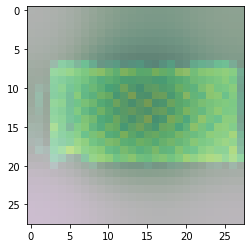

Predicted Class = 8, Probability = 0.99822146


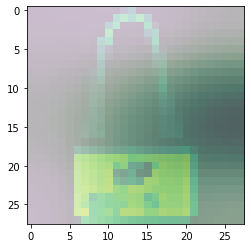

Predicted Class = 8, Probability = 0.91666543


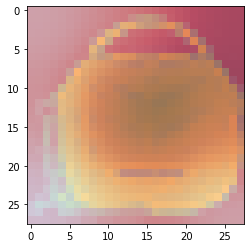

In [60]:
show_maps(desired_class=8, num_maps=20)